In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap
import mpl_toolkits.basemap.pyproj as pyproj
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics
import numpy as np
sns.set(color_codes=True)
%matplotlib inline

In [3]:
# data = pd.read_excel(r'../data/TNC_time_transit_with distance.xlsx')
# data.head()

In [4]:
# #reportject data
# wgs84=pyproj.Proj("+init=EPSG:4326")
# UTM = pyproj.Proj("+init=EPSG:2385")

In [5]:
# weight = pd.read_excel(r'../data/TNC_panel_weight.xlsx')
# weight.index = weight['month']
# weight['share_adjusted'] = weight['share (Jan=1)']/weight['share (Jan=1)'].max()
# weight

In [6]:
def resample(original_data, weight, month):
#     original_data: the original DiDi data we get;
#     weight: the weight for resample the data;
#     the month we want do the resampling
    sub_data = original_data[original_data['month']==month]
    sample = sub_data.sample(frac = float((weight.loc[month,'share_adjusted'])), replace=False,random_state=1)
    return sample

In [7]:
# data_re = pd.DataFrame()
# for i in range(1,11):
#     data_re = data_re.append(resample(data,weight,i))
# data_re.head()

In [8]:
# data_re['dest_xx'],data_re['dest_yy'] = pyproj.transform(wgs84, UTM, data_re['dest_lng'].as_matrix(),data_re['dest_lat'].as_matrix())
# data_re['starting_xx'],data_re['starting_yy'] = pyproj.transform(wgs84, UTM, data_re['starting_lng'].as_matrix(),data_re['starting_lat'].as_matrix())
# data_re.head()

140854
140852


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1,FID,id_match,month,day_of_week,starting_lng,starting_lat,dest_lng,...,start_hour,end_clock,end_hour,travel time,begin_date,finish_date,dest_xx,dest_yy,starting_xx,starting_yy
0,0,21492,21492,21492,121493,1,6,121.407162,31.164013,121.398444,...,19.971389,20:13:11,20.219722,14.900000,2015-01-06 19:58:17,2015-01-06 20:13:11,633279.691491,3454337.296290,634165.781093,3450012.881966
1,1,9488,9488,9488,109489,1,5,121.486184,31.204386,121.456390,...,14.688611,14:53:52,14.897778,12.550000,2015-01-05 14:41:19,2015-01-05 14:53:52,638805.276650,3454222.080772,641640.755653,3454588.325301
2,2,16933,16933,16933,116934,1,1,121.494585,31.245437,121.463608,...,1.025278,01:26:48,1.446667,25.283333,2015-01-01 01:01:31,2015-01-01 01:26:48,639479.248300,3455290.940158,642379.925657,3459151.304367
3,3,12604,12604,12604,112605,1,6,121.399155,31.198053,121.358284,...,18.818889,19:24:38,19.410556,35.500000,2015-01-06 18:49:08,2015-01-06 19:24:38,629431.615266,3455938.479563,633354.549795,3453777.834504
4,4,8222,8222,8222,108223,1,1,121.480010,31.225719,121.458138,...,22.200833,22:22:46,22.379444,10.716667,2015-01-01 22:12:03,2015-01-01 22:22:46,638951.075856,3455802.461066,641020.605697,3456946.058040


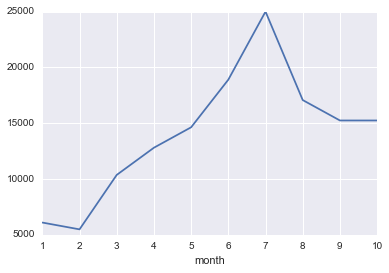

In [9]:
data_re = pd.read_csv(r'../data/TNC_time_transit_with distance_resample.csv')
print(len(data_re.index))
data_re = data_re.replace([np.inf, -np.inf], np.nan)
data_re = data_re.dropna()
print(len(data_re.index))
data_re.groupby('month').count()['FID'].plot()
data_re.head()
# data_re.to_csv(r'../data/TNC_time_transit_with distance_resample.csv')

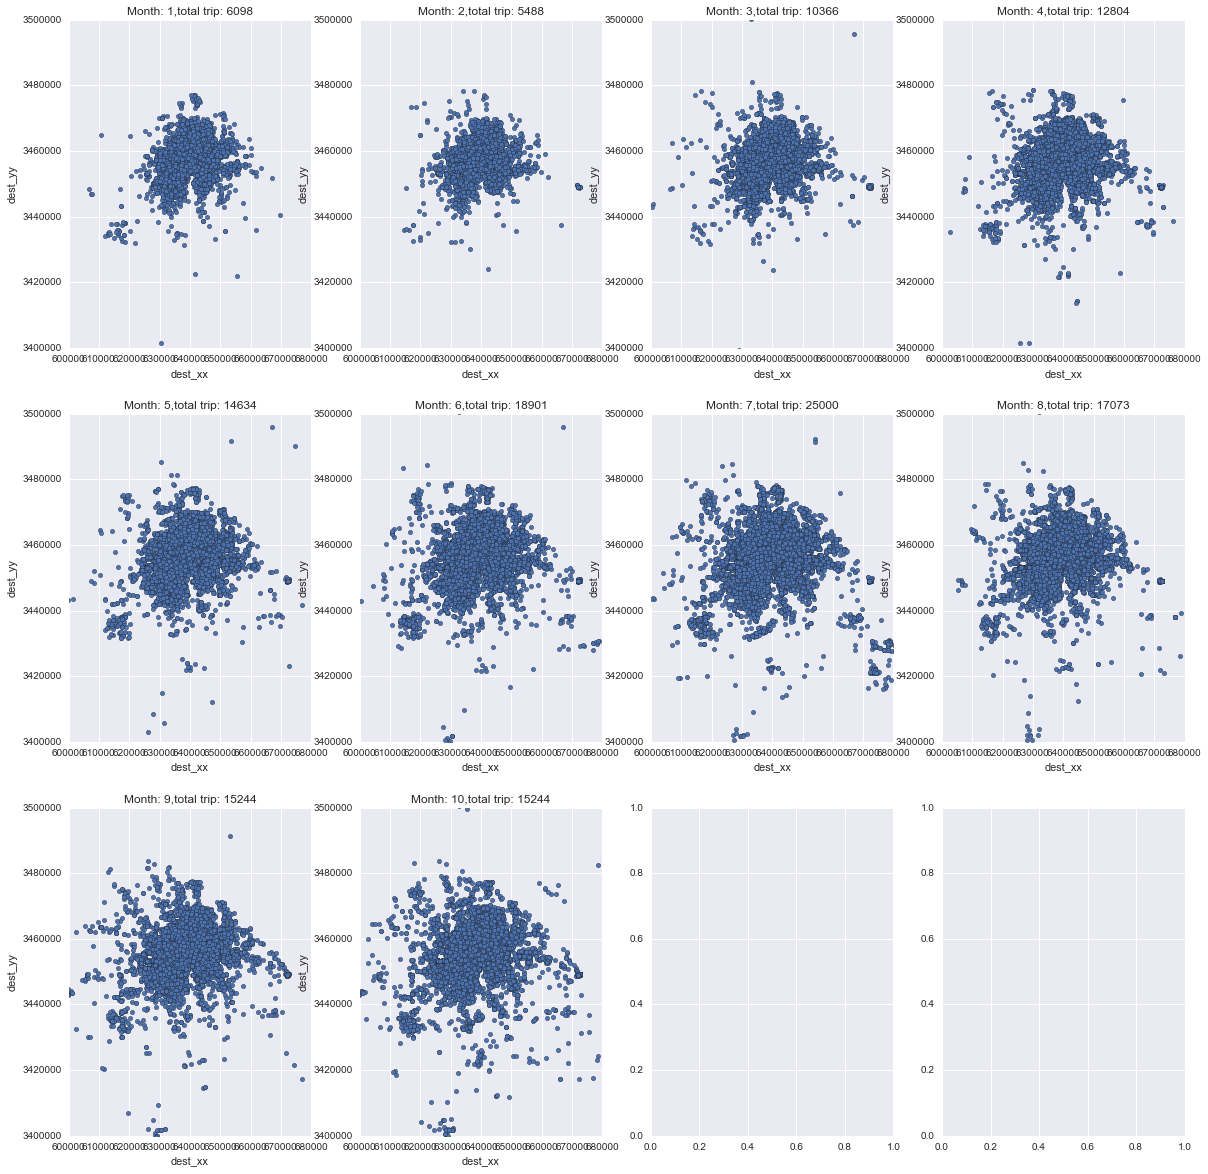

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=4,figsize=(20,20))
for i in range(1,11): 
#     ax = data_re[data_re['month']==i].plot(x= 'dest_lng',y = 'dest_lat',kind = 'scatter',figsize = (5,10))
    ax = data_re[data_re['month']==i].plot(x="dest_xx", y="dest_yy",kind="scatter",ax = axes[int((i-1)/4),(i-1)%4]);
#     data_re[data_re['month']==i].to_csv(r'../data/resampled_%s.csv'%i)
    ax.set_title('Month: %s,total trip: %s'%(i,len(data_re[data_re['month']==i].index)))
    ax.set_xlim(600000, 680000)
    ax.set_ylim(3400000,3500000)

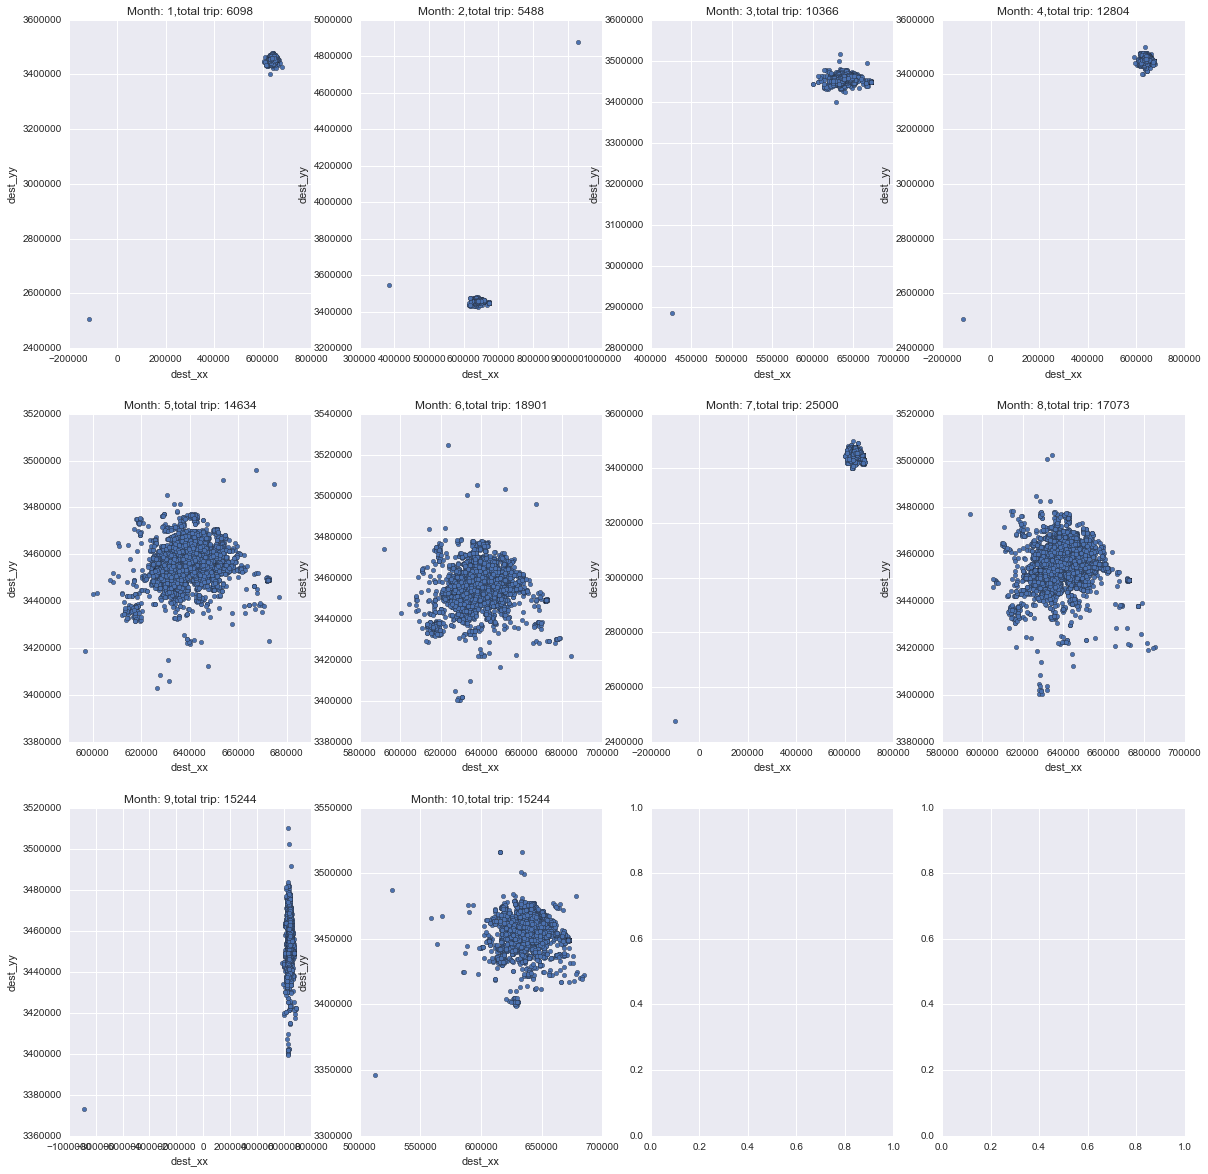

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=4,figsize=(20,20))
for i in range(1,11):
    
#     ax = data_re[data_re['month']==i].plot(x= 'dest_lng',y = 'dest_lat',kind = 'scatter',figsize = (5,10))
    ax = data_re[data_re['month']==i].plot(x="dest_xx", y="dest_yy",kind="scatter",ax = axes[int((i-1)/4),(i-1)%4]);
    ax.set_title('Month: %s,total trip: %s'%(i,len(data_re[data_re['month']==i].index)))

### let's run dbscan

In [12]:
# define the DBSCAN parameters
eps = 200
min_samples = 2

In [13]:
# run the dbscan clustering
def db(sub,eps,min_samples,od):
    X = sub[[od+'_xx',od+'_yy']].as_matrix()
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    return labels,n_clusters_
#     core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
#     core_samples_mask[db.core_sample_indices_] = True

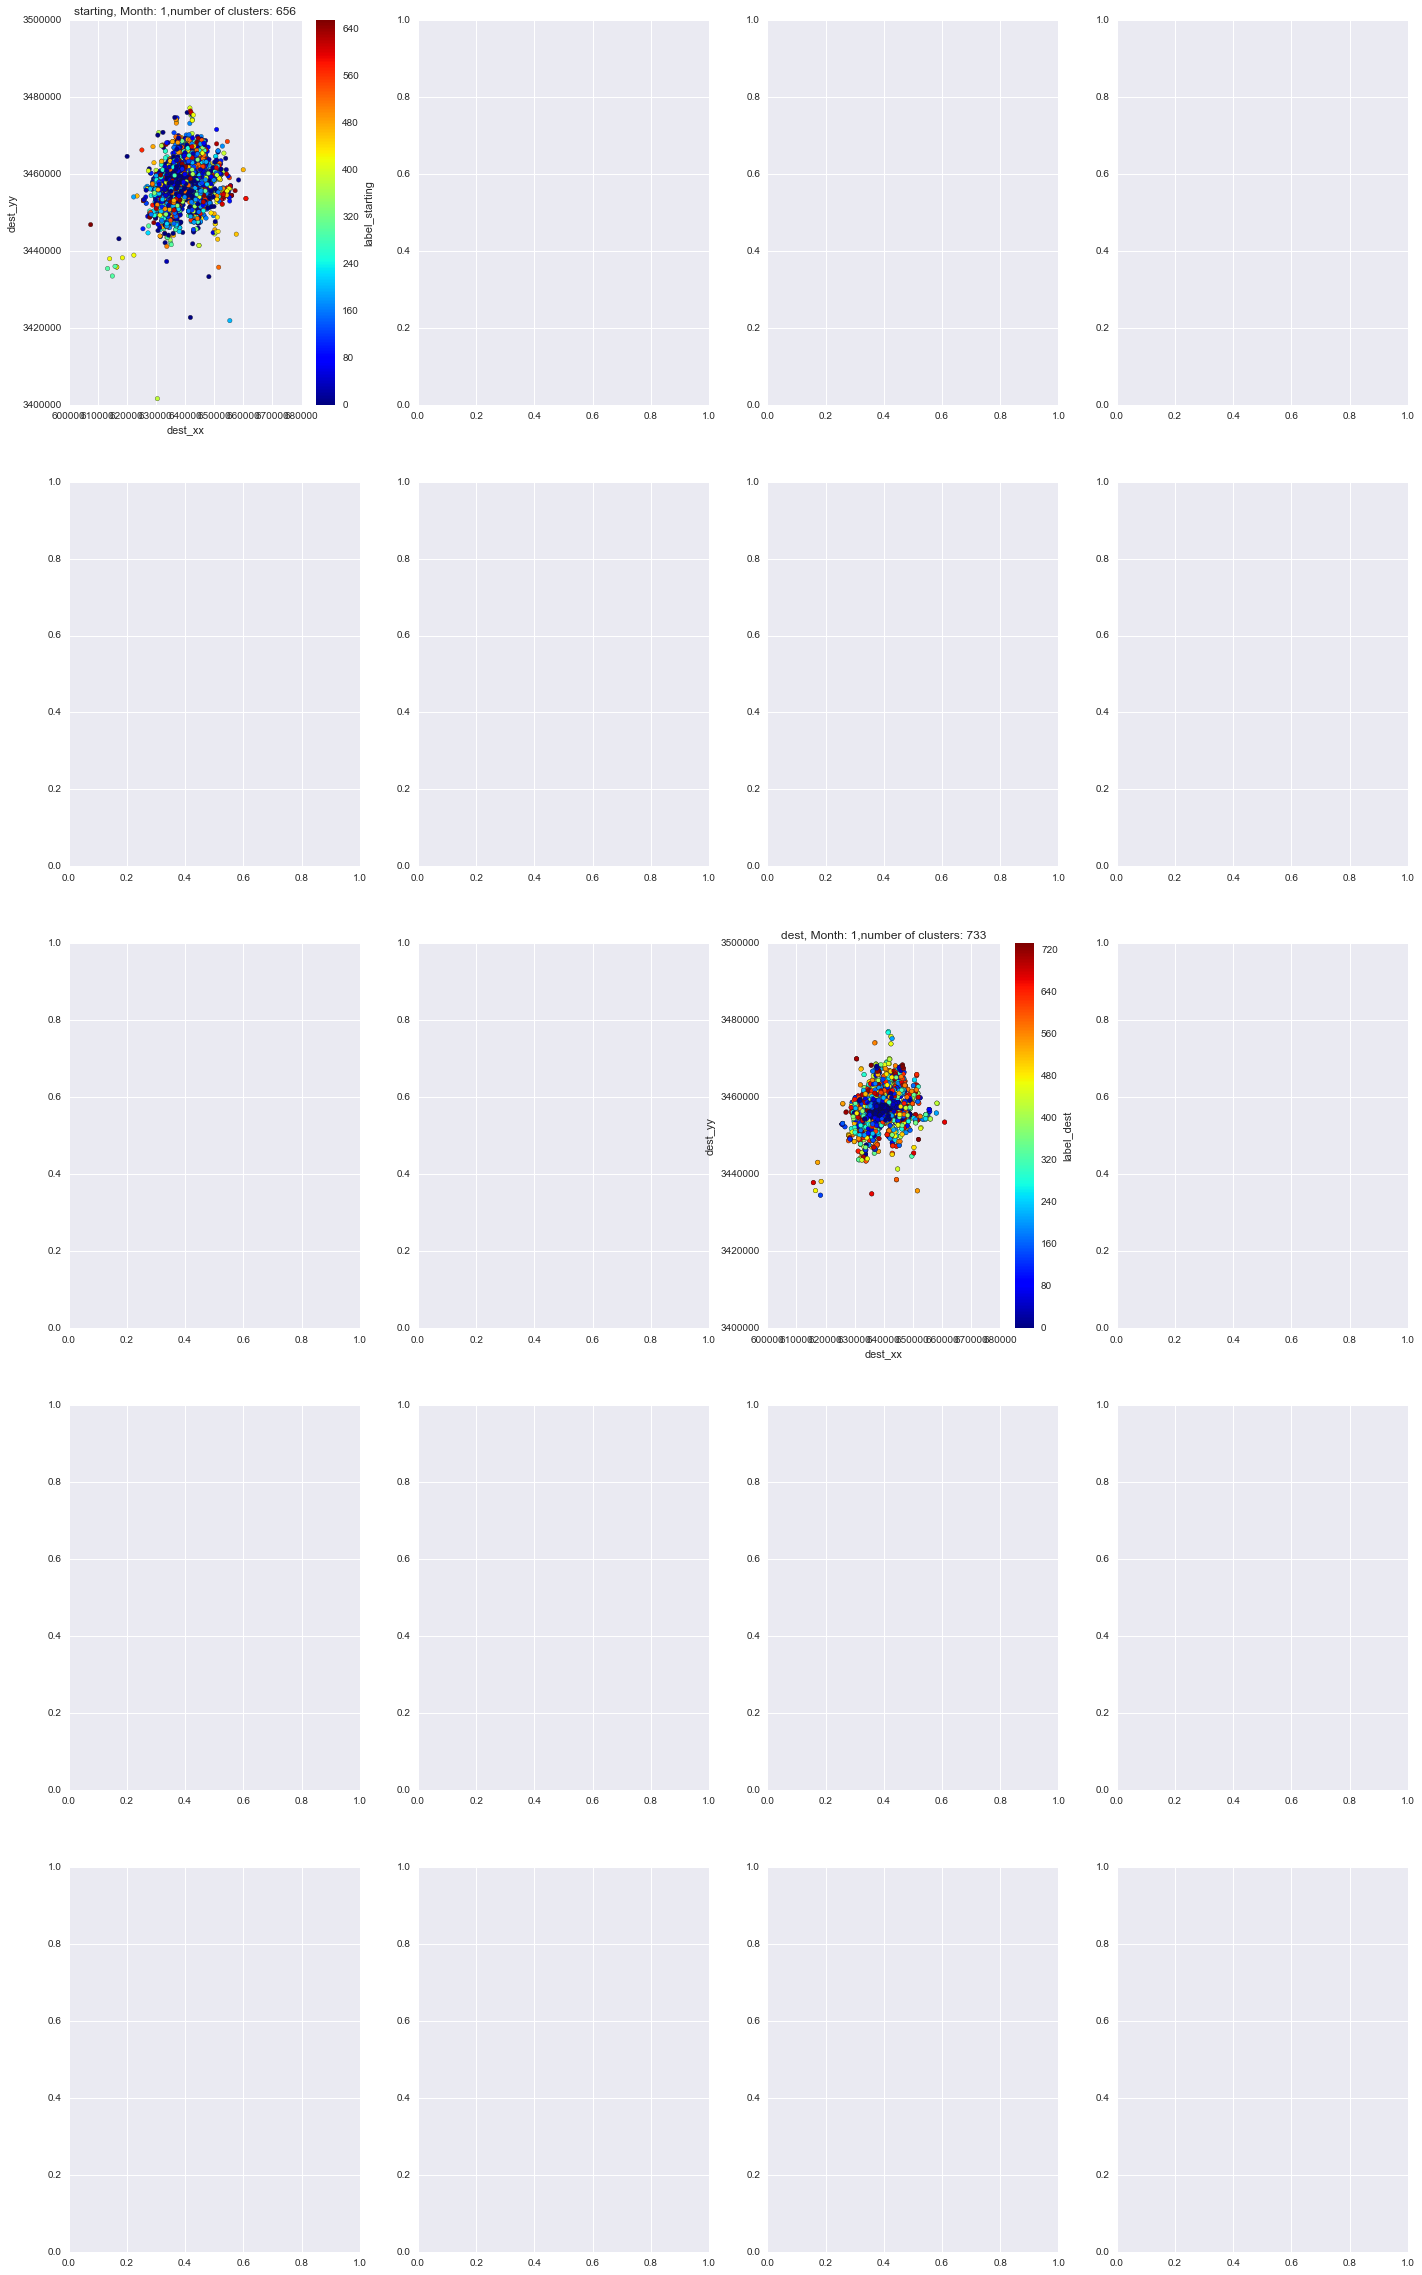

In [22]:
fig, axes = plt.subplots(nrows=5, ncols=4,figsize=(24,40))
for i in range(1,2):
    od = 'starting'
    sub = data_re.loc[data_re['month']==i]
    labels, n_clusters_ = db(sub,eps,min_samples,od)
    lab = pd.DataFrame(labels,index = sub.index)
    lab.columns = ['label_%s'%od]
    sub = sub.merge(lab,left_index=True, right_index=True,how ='inner')
    ax = sub[sub['label_%s'%od]!=-1].plot(x='dest_xx',y='dest_yy',kind='scatter',c='label_%s'%od,colormap='jet',ax = axes[int((i-1)/4),(i-1)%4]);
    ax.set_title('%s, Month: %s,number of clusters: %s'%(od,i,n_clusters_))
    ax.set_xlim(600000, 680000)
    ax.set_ylim(3400000,3500000)
    #######################################################################
    od = 'dest'
    labels, n_clusters_ = db(sub,eps,min_samples,od)
    lab = pd.DataFrame(labels,index = sub.index)
    lab.columns = ['label_%s'%od]
    sub = sub.merge(lab,left_index=True, right_index=True,how ='inner')
    ax = sub[sub['label_%s'%od]!=-1].plot(x='dest_xx',y='dest_yy',kind='scatter',c='label_%s'%od,colormap='jet',ax = axes[int((i+10-1)/4),(i+10-1)%4]);
    ax.set_title('%s, Month: %s,number of clusters: %s'%(od,i,n_clusters_))
    ax.set_xlim(600000, 680000)
    ax.set_ylim(3400000,3500000)
    sub.to_csv(r'../data/month_%s.csv'%str(i))
# use the silhouette_score to indiciate how well the clustering works, closer to 1 is better
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(X, labels))

(0, 100)

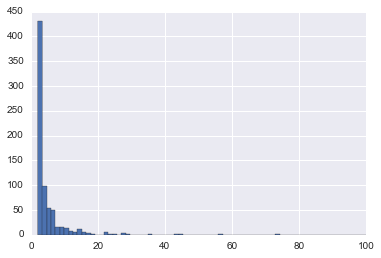

In [23]:
ax = sub.groupby('label_dest').count()['FID'].hist(bins=1000)
ax.set_xlim(0, 100)